# Edward Thorp 可转债套利策略 - 入门指南

本 Notebook 将引导您了解 Edward Thorp 风格的可转债套利策略，并展示如何使用本项目进行学习和研究。

## 目录

1. [项目概述](#项目概述)
2. [策略核心思想](#策略核心思想)
3. [快速开始](#快速开始)
4. [下一步](#下一步)

## 项目概述

本项目是一个面向学习与研究的「可转债套利策略」开源项目，灵感来自 Edward Thorp 的经典可转债套利框架。

### 核心策略

**买入低估的可转换债券 + 动态 Delta 对冲做空股票**，以获取定价错误收益并尽量规避市场方向性风险。

### 项目目标

- 系统性地展示可转债市场中性套利策略的核心思想与实现路径
- 提供从数据处理、定价建模、信号生成、Delta 对冲到回测评估的完整链路
- 作为学习和研究可转债套利策略的「实验室」

## 策略核心思想

### 1. 可转债的结构

可转债 = **纯债部分** + **转股期权部分** + **条款效应**

- **纯债部分（Bond Floor）**：假设永远不行使转换权，只按债券条款收取票息和本金
- **转股期权部分**：持有人有权按固定转换比例将债券转换为股票
- **条款效应**：赎回、回售、重置等条款的影响

### 2. 套利机会的来源

当可转债的市场价格明显低于其理论公允价值时，存在「低估」机会。

### 3. 市场中性组合

- **多头腿**：买入被低估的可转债
- **空头腿**：按 Delta 对冲比例卖空对应数量的标的股票
- **目标**：使组合对股价的一阶敏感度（Delta）接近 0，消除方向性风险

## 快速开始

让我们先导入必要的库并查看项目结构。

In [2]:
import sys
import os

# 添加 src 目录到 Python 路径（支持从项目根或 notebooks 目录运行）
cwd = os.getcwd()
project_root = cwd if os.path.isdir(os.path.join(cwd, 'src')) else os.path.abspath(os.path.join(cwd, '..'))
src_dir = os.path.join(project_root, 'src')
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# 导入项目模块
from cb_arb.params import ConvertibleBondContract, TermStructure, CreditCurve
from cb_arb.cb_pricing import price_convertible_bond_binomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 导入 Notebook 工具函数（用于保存输出文件）
notebooks_dir = os.path.join(project_root, 'notebooks')
if notebooks_dir not in sys.path:
    sys.path.insert(0, notebooks_dir)
from notebook_utils import save_figure, get_figures_dir, get_data_dir

print("✅ 模块导入成功！")
print(f"项目根目录: {project_root}")
print(f"src 目录已添加到 Python 路径: {src_dir}")
print(f"输出目录: {os.path.join(project_root, 'output')}")

✅ 模块导入成功！
项目根目录: d:\Gitstars\Edward Thorp
src 目录已添加到 Python 路径: d:\Gitstars\Edward Thorp\src


### 示例：创建一个简单的可转债合约

让我们创建一个示例可转债合约，并计算其理论价格和 Delta。

In [3]:
# 定义可转债合约参数
contract = ConvertibleBondContract(
    face_value=100.0,          # 面值 100 元
    coupon_rate=0.03,          # 年化票息率 3%
    maturity=3.0,              # 到期时间 3 年
    conversion_ratio=1.0,      # 转换比例：1 张债 = 1 股
    issue_price=100.0,         # 发行价 100 元
    call_price=None,           # 无赎回条款
    put_price=None,            # 无回售条款
    coupon_freq=2,             # 半年付息
)

# 定义期限结构（简化：平坦曲线）
r_curve = TermStructure(rate_fn=lambda t: 0.02)  # 无风险利率 2%
q_curve = TermStructure(rate_fn=lambda t: 0.01)  # 股利率 1%
credit_curve = CreditCurve(spread_fn=lambda t: 0.03)  # 信用利差 3%

# 定价参数
S0 = 100.0  # 当前股价
vol = 0.25  # 波动率 25%
steps = 50  # 二叉树步数

# 计算可转债价格和 Delta
price, delta = price_convertible_bond_binomial(
    S0=S0,
    contract=contract,
    steps=steps,
    vol=vol,
    r_curve=r_curve,
    q_curve=q_curve,
    credit_curve=credit_curve,
)

print(f"当前股价: {S0:.2f}")
print(f"可转债理论价格: {price:.4f}")
print(f"可转债 Delta: {delta:.4f}")
print(f"\n解释：")
print(f"- 如果股价上涨 1 元，可转债价格大约上涨 {delta:.4f} 元")
print(f"- Delta 接近 1.0 表示可转债更像股票")
print(f"- Delta 接近 0.0 表示可转债更像债券")

当前股价: 100.00
可转债理论价格: 108.0818
可转债 Delta: 0.6280

解释：
- 如果股价上涨 1 元，可转债价格大约上涨 0.6280 元
- Delta 接近 1.0 表示可转债更像股票
- Delta 接近 0.0 表示可转债更像债券


### 可视化：Delta 随股价变化

让我们看看当股价变化时，可转债的 Delta 如何变化。

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 20538 (\N{CJK UNIFIED IDEOGRAPH-503A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21112\2627839599.py:38: UserWarning: Glyph 26

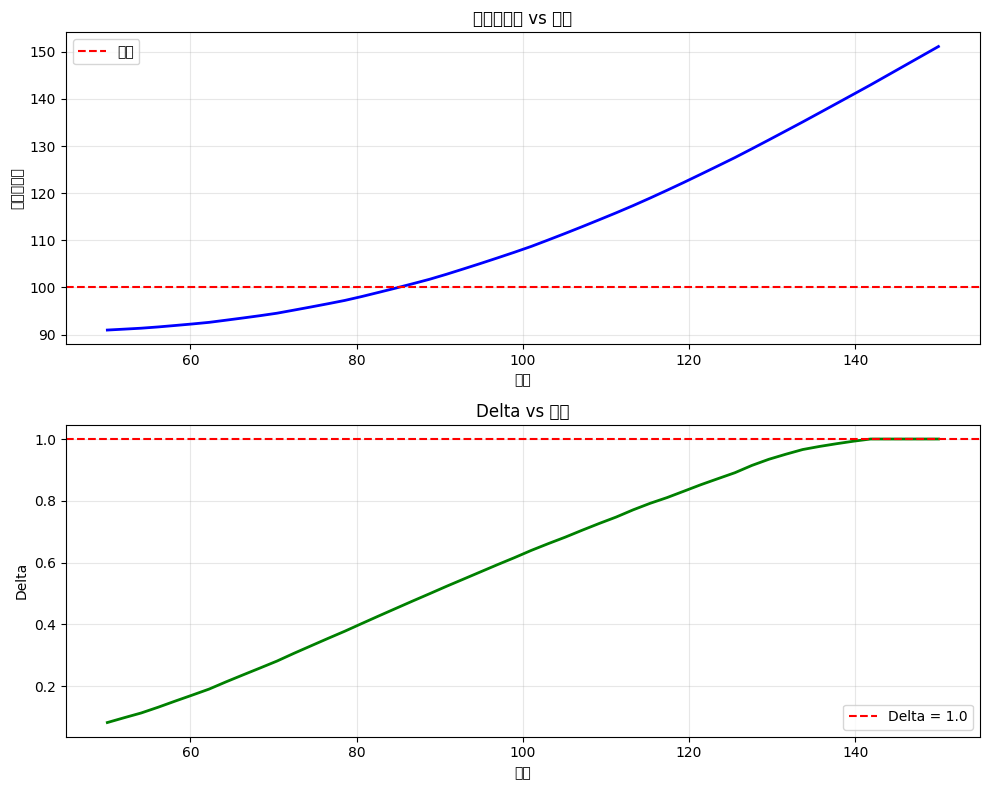

观察：
- 当股价很低时，Delta 接近 0（更像债券）
- 当股价很高时，Delta 接近转换比例（更像股票）
- 在中间区域，Delta 快速变化（这是 Delta 对冲的关键区域）


In [4]:
# 生成不同股价下的 Delta
stock_prices = np.linspace(50, 150, 50)
deltas = []
prices = []

for S in stock_prices:
    p, d = price_convertible_bond_binomial(
        S0=S,
        contract=contract,
        steps=steps,
        vol=vol,
        r_curve=r_curve,
        q_curve=q_curve,
        credit_curve=credit_curve,
    )
    prices.append(p)
    deltas.append(d)

# 绘图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(stock_prices, prices, 'b-', linewidth=2)
ax1.axhline(y=contract.face_value, color='r', linestyle='--', label='面值')
ax1.set_xlabel('股价')
ax1.set_ylabel('可转债价格')
ax1.set_title('可转债价格 vs 股价')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(stock_prices, deltas, 'g-', linewidth=2)
ax2.axhline(y=1.0, color='r', linestyle='--', label='Delta = 1.0')
ax2.set_xlabel('股价')
ax2.set_ylabel('Delta')
ax2.set_title('Delta vs 股价')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# 保存图片到项目 output/figures 目录
save_figure(fig, '01_introduction_delta_vs_stock_price')

plt.show()

print("观察：")
print("- 当股价很低时，Delta 接近 0（更像债券）")
print("- 当股价很高时，Delta 接近转换比例（更像股票）")
print("- 在中间区域，Delta 快速变化（这是 Delta 对冲的关键区域）")

## 下一步

现在您已经了解了项目的基本概念，可以继续学习：

1. **02_pricing_demo.ipynb** - 深入了解定价模型的数学原理和实现细节
2. **03_delta_hedging.ipynb** - 学习如何构建市场中性组合
3. **04_signal_generation.ipynb** - 了解如何识别错定价机会
4. **05_backtest_analysis.ipynb** - 学习如何回测策略表现

### 运行完整回测示例

您也可以直接运行示例脚本：

```bash
python -m examples.run_simple_backtest
```

这将运行一个完整的回测示例，展示策略的完整流程。

---

**重要提示**：本项目仅用于学术研究与教育目的，不构成任何投资建议。